In [1]:
import numpy as np
import pandas as pd
import time
import sys
import os
import h5py
from joblib import Parallel, delayed
sys.path.append('../')
from packages import actv_analysis, svm, load_csv, stats, objects, test_codes
import pickle
import re
import glob
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Go two directories up
up_two_dir = os.path.dirname(current_dir)

print(up_two_dir)

/Users/dongillee/Interference/codes


In [ ]:
net=1; relu=4; epoch=90
actv_net = actv_analysis.get_actv_net(net=net, relu=relu, epoch=epoch)

In [ ]:
pkl_filename = f'{up_two_dir}/fig1/pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'

# Load units from the pickle file
with open(pkl_filename, 'rb') as f:
    units = pickle.load(f)

In [ ]:
actv_net3D = np.mean(actv_net,axis=2).reshape(actv_net.shape[0],10,10)[:,1:,3:]

In [ ]:
kk = actv_net3D[1232,:,:]

In [ ]:
unit_actv_3D.shape

In [ ]:
import statsmodels.api as sm

# Create a DataFrame for convenience
df = pd.DataFrame(kk)
# Convert the DataFrame column names to strings
df.columns = df.columns.astype(str)


# Fit AR(1) model for each column
results = []
for column in df.columns:
    model = sm.tsa.AutoReg(df[column], lags=2)
    result = model.fit()
    results.append(result)

# Print the parameters for each model
for i, result in enumerate(results):
    print(f"Column {i+1} - AutoReg(1) coefficient: {result.params[1]}")

In [26]:
import pickle
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

def fit_ARmodel(net, epoch, relu, lag):
    print(f"Processing for net: {net}, epoch: {epoch}")
    temp_results = []

    actv_net = actv_analysis.get_actv_net(net=net, relu=relu, epoch=epoch)
    avg_actv_net_nxs = np.mean(actv_net, axis=2).reshape(actv_net.shape[0], 10, 10)[:, 1:, 3:]
    pkl_filename = f'{up_two_dir}/fig1/pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'

    scaler = StandardScaler()

    with open(pkl_filename, 'rb') as f:
        units = pickle.load(f)

    for unit_index, unit in enumerate(units):
        matrix = avg_actv_net_nxs[unit_index]
        matrix_normalized = scaler.fit_transform(matrix.reshape(-1, 1)).reshape(matrix.shape)
        df = pd.DataFrame(matrix_normalized, columns=['size_' + str(i) for i in range(1, 8)])
        
        # Fit AR for each column
        column_coeffs = {}
        for column in df.columns:
            model = sm.tsa.AutoReg(df[column], lags=lag)
            result = model.fit()
            coeffs = result.params.values  # Convert Series to array
            column_coeffs[column] = coeffs
        setattr(unit, f'ar_fit_numbers_lag{lag}', column_coeffs)

        # Fit AR for each row
        row_coeffs = {}
        for i, row in df.iterrows():
            model = sm.tsa.AutoReg(row.values, lags=lag)
            result = model.fit()
            coeffs = result.params  # No need to use .values here
            row_coeffs[f'row_{i}'] = coeffs
        setattr(unit, f'ar_fit_sizes_lag{lag}', row_coeffs)
        
        #print(hasattr(unit, f'ar_fit_columns_lag{lag}'))
        #print(hasattr(unit, f'ar_fit_rows_lag{lag}'))

    with open(pkl_filename, 'wb') as f:
        pickle.dump(units, f)

    return temp_results

In [59]:
from joblib import Parallel, delayed

def fit_ARmodel_unit(unit, matrix_normalized, lag):
    df = pd.DataFrame(matrix_normalized, columns=['size_' + str(i) for i in range(1, 8)])
    
    # Fit AR for each column
    column_coeffs = {}
    for column in df.columns:
        model = sm.tsa.AutoReg(df[column], lags=lag)
        result = model.fit()
        coeffs = result.params
        column_coeffs[column] = coeffs
    setattr(unit, f'ar_fit_numbers_lag{lag}', column_coeffs)

    # Fit AR for each row
    row_coeffs = {}
    for i, row in df.iterrows():
        model = sm.tsa.AutoReg(row.values, lags=lag)
        result = model.fit()
        coeffs = result.params
        row_coeffs[f'row_{i}'] = coeffs
    setattr(unit, f'ar_fit_sizes_lag{lag}', row_coeffs)

    return unit

def fit_ARmodel(net, epoch, relu, lag, n_jobs=-1):
    print(f"Processing for net: {net}, epoch: {epoch}")
    
    actv_net = actv_analysis.get_actv_net(net=net, relu=relu, epoch=epoch)
    avg_actv_net_nxs = np.mean(actv_net, axis=2).reshape(actv_net.shape[0], 10, 10)[:, 1:, 3:]
    pkl_filename = f'{up_two_dir}/fig1/pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'

    scaler = StandardScaler()

    with open(pkl_filename, 'rb') as f:
        units = pickle.load(f)

    # Parallel processing
    matrices_normalized = [scaler.fit_transform(matrix.reshape(-1, 1)).reshape(matrix.shape) for matrix in avg_actv_net_nxs]
    units = Parallel(n_jobs=n_jobs)(delayed(fit_ARmodel_unit)(unit, matrix_normalized, lag) for unit, matrix_normalized in zip(units, matrices_normalized))

    with open(pkl_filename, 'wb') as f:
        pickle.dump(units, f)

    return

# Calling the function
net=1; epoch=90; relu=4; lag=2
result = fit_ARmodel(net, epoch, relu, lag)

Processing for net: 1, epoch: 90
--- 98.27945494651794 seconds ---


In [27]:
net=1; epoch=0; relu=4; lag=2
result = fit_ARmodel(net,epoch,relu,lag)

Processing for net: 1, epoch: 0
--- 112.63349986076355 seconds ---


In [108]:
net=1; epoch=90; relu=4

pkl_filename = f'{up_two_dir}/fig1/pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'

scaler = StandardScaler()

with open(pkl_filename, 'rb') as f:
    units = pickle.load(f)

In [61]:
data_list = []

for i in range(len(units)):
    dat = units[i].ar_fit_numbers_lag2
    dat2 = units[i].ar_fit_sizes_lag2  # Note: corrected from units[0] to units[i]

    all_values = np.hstack(list(dat.values()))
    all_values2 = np.hstack(list(dat2.values()))

    all_ = np.concatenate((all_values, all_values2))
    data_list.append(all_)

final_array = np.vstack(data_list)


/Users/dongillee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


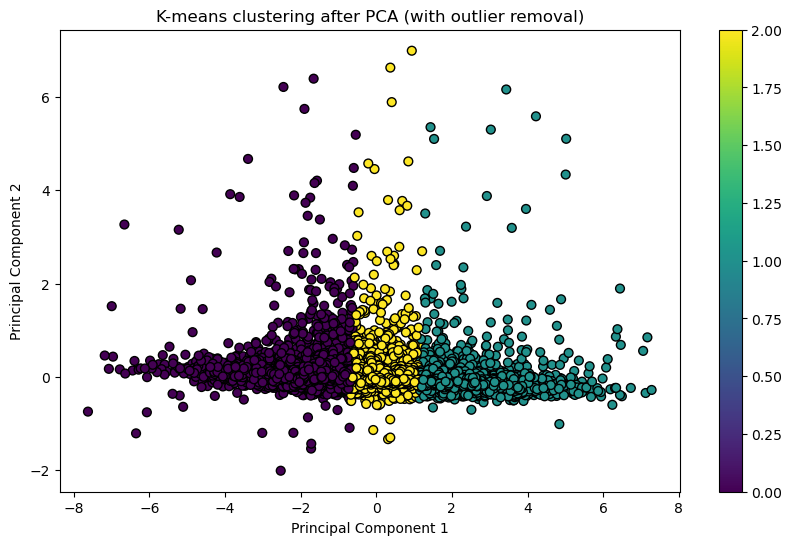

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've already constructed final_array based on our previous discussions

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_array)

# Applying PCA
pca = PCA(n_components=2)  
pca_result = pca.fit_transform(scaled_data)

# Compute the distance of each point in PCA space
distances = np.linalg.norm(pca_result, axis=1)

# Determine a threshold to identify outliers
mean_distance = np.mean(distances)
std_distance = np.std(distances)
threshold = mean_distance + 3*std_distance  

# Filter out the outliers
is_outlier = distances > threshold
filtered_data = scaled_data[~is_outlier]  # Original data without outliers
filtered_pca_data = pca_result[~is_outlier]  # PCA-transformed data without outliers

# Now clustering the filtered PCA data
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(filtered_pca_data)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(filtered_pca_data[:, 0], filtered_pca_data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=40)
plt.colorbar()
plt.title('K-means clustering after PCA (with outlier removal)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [110]:
result = np.array([[units[i].kendall_stats['averaged_across_sizes']['tau'], 
                    units[i].kendall_stats['averaged_across_numbers']['tau']] for i in range(len(units))])

res = pd.DataFrame(result).dropna()

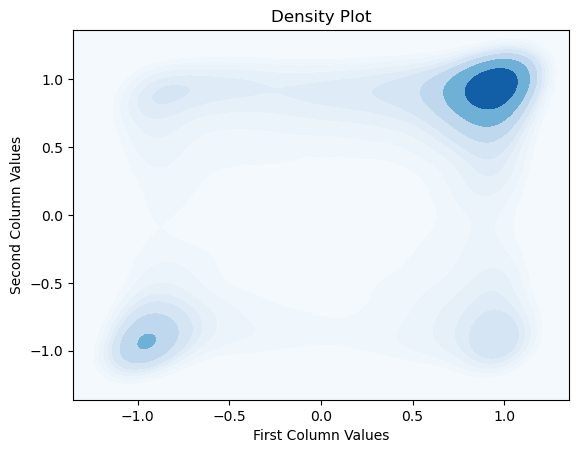

In [111]:
sns.kdeplot(data=res, x=res.columns[0], y=res.columns[1], fill=True, cmap='Blues', thresh=0)
plt.title('Density Plot')
plt.xlabel('First Column Values')
plt.ylabel('Second Column Values')
plt.show()